# Segmentació d’Imatges amb U-Net

En aquesta pràctica treballarem amb U-Net, una de les arquitectures més utilitzades en tasques de segmentació d'imatges. L'objectiu principal és consolidar els coneixements teòrics adquirits, implementant i experimentant amb aquesta xarxa utilitzant un conjunt de dades artificial i simple.

La segmentació d'imatges és una tasca fonamental en visió per computador, ja que permet classificar cada píxel d'una imatge en una o més categories. En aquesta pràctica, el nostre objectiu serà entrenar una xarxa U-Net perquè pugui identificar regions específiques dins d’imatges generades artificialment. Aquest enfocament simplificat permetrà concentrar-nos en els aspectes clau de la implementació i el funcionament del model, sense les complicacions que podrien sorgir amb conjunts de dades més complexos.

El conjunt de dades que utilitzarem estarà format per imatges sintètiques que contenen formes geomètriques bàsiques (com cercles, quadrats o creus), amb les seves corresponents màscares que indiquen les àrees que cal segmentar. Això ens permetrà obtenir resultats visuals ràpidament i entendre millor com la xarxa aprèn a identificar patrons específics.

L'arquitectura que emprarem es pot utilitzar, per problemes més complexes, però amb les limitacions temporals que tenim no es recomenable.

In [12]:
from collections import OrderedDict
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm

## Dataset

Emprarem un dataset sintètic. Aquest originalment s'emprava per dur a terme tasques de Intel·ligència Artificial Explicable (XAI). Nosaltres ho emprarem per dur a terme una tasca de segmentació. Podeu trobar el dataset complet al següent [enllaç](https://github.com/miquelmn/aixi-dataset/releases/tag/1.5.0).

![Imatges dataset](https://ars.els-cdn.com/content/image/1-s2.0-S0004370224001152-gr001.jpg)

L'objectiu amb aquest dataset es segmentar del fons les formes geomètriques, emprant una U-Net. Nosaltres i a causa de les limitacions temporals que tenim i de recursos emprarem una versió [reduida](https://github.com/miquelmn/aa_2526/releases/tag/pr9).

In [13]:
!unzip mini_txuxi.zip -d /content/

Archive:  mini_txuxi.zip
replace /content/mini/train/image/00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/mini/train/image/00000.png  
  inflating: /content/mini/train/image/00001.png  
  inflating: /content/mini/train/image/00002.png  
  inflating: /content/mini/train/image/00003.png  
  inflating: /content/mini/train/image/00004.png  
  inflating: /content/mini/train/image/00005.png  
  inflating: /content/mini/train/image/00006.png  
  inflating: /content/mini/train/image/00007.png  
  inflating: /content/mini/train/image/00008.png  
  inflating: /content/mini/train/image/00009.png  
  inflating: /content/mini/train/image/00010.png  
  inflating: /content/mini/train/image/00011.png  
  inflating: /content/mini/train/image/00012.png  
  inflating: /content/mini/train/image/00013.png  
  inflating: /content/mini/train/image/00014.png  
  inflating: /content/mini/train/image/00015.png  
  inflating: /content/mini/train/image/00016.png  
  inflating: /content/m

# Dataset de segmentació

A l’hora de treballar amb tasques de segmentació d’imatges, és essencial tenir un conjunt de dades que inclogui tant les imatges d’entrada com les màscares que representen les etiquetes de segmentació. Un dataset per segmentació ha de contenir:

1. Imatges d’entrada: Aquestes són les imatges que el model utilitzarà per aprendre. Poden estar en formats com JPEG o PNG.
2. Màscares de segmentació: Cada màscara és una imatge on cada píxel té un valor que representa la classe a la qual pertany (per exemple, 0 per fons, 1 per objecte). Les màscares han de tenir la mateixa mida que les imatges d’entrada.

In [14]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms

class Formes(Dataset):
    """
    TXUKI segmentation dataset.

    CORRECCIÓ: Aquesta versió accepta llistes de rutes de fitxers ja pre-seleccionades,
    en lloc d'una única ruta de directori.
    """
    # El constructor ara espera llistes de rutes completes (img_files, label_files)
    def __init__(self, img_files, mask_files, transform=None):
        # NOTA: Canviem 'img_dir' i 'mask_dir' per 'img_files' i 'mask_files'

        # Guardem directament les llistes de rutes completes
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        self.transform = transform

        # Definim les transformacions de màscara només una vegada
        self.mask_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.squeeze().long()) # (C, H, W) -> (H, W) amb dtype int64
        ])

        # Si es proporciona un transform, assumim que només afecta a la imatge
        self.image_only_transforms = self.transform or transforms.ToTensor()


    def __len__(self):
        # Retorna la longitud de la llista de fitxers
        return len(self.img_filenames)


    def __getitem__(self, idx):
        # Utilitzem directament les rutes completes guardades
        img_path = self.img_filenames[idx]
        mask_path = self.mask_filenames[idx]

        # 1. Carregar imatge i màscara
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # 2. Aplicar transformacions
        # Aplicar les transformacions de la imatge (ToTensor i Normalització)
        image = self.image_only_transforms(image)

        # Aplicar les transformacions de la màscara (ToTensor i LongTensor)
        mask = self.mask_transforms(mask)

        return image, mask

Per instanciar aquest tipus de dataset es similar a com ho hem fet fins ara. **Per tal de simplificar l'entrenament només emprarem 500 mostres per l'entrenament i 200 de test**.

In [15]:
PATH_DADES = "./mini"  # POSA EL TEU!
# Dades entrenament
path_train = f"{PATH_DADES}/train"

img_files = sorted(glob(path_train + "/image/*.png"))
label_files = sorted(glob(path_train + "/mask/*.png"))
img_files = img_files[:500]
label_files = label_files[:500]

print("total training images", len(img_files))

# Dades validacio

path_val = f"{PATH_DADES}/val"
img_files_val = sorted(glob(path_val + "/image/*.png"))
label_files_val = sorted(glob(path_val + "/mask/*.png"))
img_files_val = img_files_val[:200]
label_files_val = label_files_val[:200]

print("total test images", len(img_files_val))

total training images 500
total test images 200


In [16]:
train_batch_size = 4
test_batch_size = 4

# Definim una seqüència (composició) de transformacions
transform = transforms.Compose([
    transforms.ToTensor(),
    ## TODO: Put if necessary
])

train_data = Formes(img_files, label_files, transform)
val_data = Formes(img_files_val, label_files_val, transform)

train_loader = torch.utils.data.DataLoader(train_data, train_batch_size)
val_loader = torch.utils.data.DataLoader(val_data, test_batch_size)

## Entrenament
L’entrenament d’una xarxa U-Net consisteix a ensenyar al model a predir les màscares de segmentació corresponents a les imatges d’entrada. Aquest procés implica ajustar els pesos de la xarxa per minimitzar l’error entre les prediccions i les etiquetes reals (màscares). En aquesta secció, configurarem tot el necessari per entrenar el model amb el conjunt de dades generat prèviament.

Hi ha tot un conjunt de peculiaritats que fan que aquest entrenament difereixi respecte els vists fins ara:
- **Funció de pèrdua**. El Dice Coefficient és una mesura d’avaluació utilitzada en segmentació d’imatges per comparar la superposició entre la màscara predita i la màscara real. El seu valor oscil·la entre 0 (cap coincidència) i 1 (coincidència perfecta), i es calcula com el doble de la intersecció entre les dues màscares dividit per la seva suma total. També es pot emprar ``BCE``.
- **Sortida de la xarxa**. El tipus de problema determina el nombre de canals de sortida de la U-Net: per segmentació binària, la sortida és un únic canal amb valors que representen la probabilitat de pertànyer a la classe positiva (fons o objecte). En canvi, per segmentació multiclasse, la sortida té un canal per a cada classe i els valors representen la probabilitat de cada píxel de pertànyer a cadascuna de les classes.
- **Funcions d'activació**. Les funcions d'activació a la sortida d'una U-Net depenen del tipus de segmentació: en segmentació binària, s'utilitza una sigmoid per comprimir els valors entre 0 i 1, representant la probabilitat de pertànyer a la classe positiva. En segmentació, **sense superposició**, multiclasse, s'aplica una softmax per convertir els valors de cada canal en probabilitats normalitzades, assegurant que la suma sigui 1 per píxel.

### El model

In [20]:
import torch.nn as nn

class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetConvBlock, self).__init__()

        # El bloc conté dues operacions seqüencials de Conv -> BatchNorm -> ReLU
        self.block = nn.Sequential(
            # Primera Convolució (3x3 amb padding=1 per mantenir la mida espacial)
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True),

            # Segona Convolució
            nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Simplement passa l'entrada a través de la seqüència de capes
        return self.block(x)

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        # 1. ENCODER (Path Contractant)
        self.encoder1 = UNetConvBlock(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = UNetConvBlock(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = UNetConvBlock(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = UNetConvBlock(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2. BOTTLENECK
        self.bottleneck = UNetConvBlock(features * 8, features * 16)

        # 3. DECODER (Path Expansiu)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNetConvBlock(features * 16, features * 8)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNetConvBlock(features * 8, features * 4)

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNetConvBlock(features * 4, features * 2)

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNetConvBlock(features * 2, features)

        # 4. CAPA DE SORTIDA (Convolució 1x1 per mapejar al nombre de classes)
        self.conv_out = nn.Conv2d(features, out_channels, kernel_size=1)


    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)

        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        bottleneck = self.bottleneck(p4)

        # Decoder amb Skip Connections (Concat)
        d4 = self.upconv4(bottleneck)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        # Sortida (Logits)
        output = self.conv_out(d1)

        return output


## La funció de pèrdua

Per fer tasques de segmentació, una de les funcions de pèrdua que podem emprar és el _Diceloss_ (intersecció vs unió):  El coeficient de _Dice_ s'utilitza habitualment en tasques de segmentació d'imatges com a mesura de la superposició entre les màscares de segmentació entre la predicció i el _ground truth_. El  _Diceloss_, és el complementari del coeficient de _Dice_, es pot utilitzar com a funció de pèrdua per entrenar models per a tasques de segmentació.

Dice Coefficient $= 2 \times \frac{|X \cap Y|}{|X| + |Y|}$



On:

- $X$ és la màscara de segmentació prevista.
- $Y$ és la màscara de segmentació de la veritat del sòl.
- $∣⋅∣$ denota la cardinalitat o el nombre d'elements d'un conjunt.

In [18]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

### Bucle d'entrenament

El bucle d'entrenament és un poc diferent al vist fins ara. En particular, en aquests moments els gràfics es van actualitzant a mesura que aprèn i així podem tenir un idea de cm va l'entrenament.

In [23]:
import torch.nn as nn
import torch

class BCELoss(nn.Module):
    """
    Classe que encapsula nn.BCEWithLogitsLoss.
    Aquesta loss és ideal per a segmentació binària amb sortides de logits,
    ja que gestiona la Sigmoid internament per a una millor estabilitat numèrica.
    """
    def __init__(self):
        super().__init__()
        # Utilitzem BCEWithLogitsLoss de PyTorch
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_true):
        # BCEWithLogitsLoss espera que el target (y_true) sigui del tipus float.
        # Ho convertim a float just abans de calcular la pèrdua.
        return self.loss(y_pred, y_true.float())

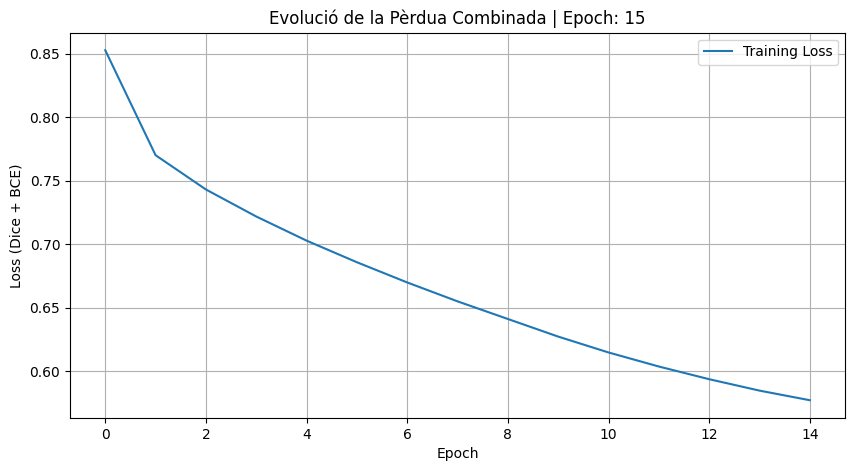

Entrenament finalitzat.


In [24]:
# --- CONFIGURACIÓ ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilitzant dispositiu: {device}")

# out_channels=1 per a segmentació binària (Fons vs. Formes)
model = UNet(in_channels=3, out_channels=1, init_features=32).to(device)

# Paràmetres
learning_rate = 1e-4
num_epochs = 15 # Valor suggerit per veure progressos
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Funció de pèrdua combinada (Exemple: Ponderació de les dues pèrdues)
criterion_dice = DiceLoss()
criterion_bce = BCELoss()

# Llista per guardar l'historial
train_losses = []

# --- BUCLE D'ENTRENAMENT ---
print("Començant l'entrenament...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Utilitzem tqdm per a una barra de progrés
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

    for i, (images, masks) in enumerate(train_loop):
        images, masks = images.to(device), masks.to(device)

        # La UNet espera C=1 a la sortida, així que afegim la dimensió de canal a la màscara (B, H, W) -> (B, 1, H, W)
        masks_input = masks.unsqueeze(1)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Càlcul de la pèrdua: Pèrdua combinada
        loss_dice = criterion_dice(outputs, masks_input)
        loss_bce = criterion_bce(outputs, masks_input)

        # Ponderació 50/50 per beneficiar-se d'ambdues
        loss = 0.5 * loss_bce + 0.5 * loss_dice

        # Backward pass i optimització
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Actualitzar la barra de progrés
        train_loop.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Actualització visual del gràfic
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title(f"Evolució de la Pèrdua Combinada | Epoch: {epoch+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Dice + BCE)")
    plt.legend()
    plt.grid(True)
    display.display(plt.gcf())
    plt.close()

print("Entrenament finalitzat.")

# Tasques a fer

1. Implementa la U-Net per detectar les formes geomètriques.
2. Empra com a funció de pèrdua tant la ``Dice`` com la ``BCE``, quina diferència hi ha?
3. Fer un nou entrenament per segmentar de forma separada els diferents tipus de figura. Has d'adaptar el model. Quins canvis faries?